# 1. Здійсніть імпорт необхідних бібліотек.


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## 2. Підготовка даних:

In [2]:
import os
os.chdir(r"c:\Users\anton\PythonProjects\Neoversity\deep learning\hw1")
print("Новий робочий каталог:", os.getcwd())


Новий робочий каталог: c:\Users\anton\PythonProjects\Neoversity\deep learning\hw1


In [3]:
# Завантажуємо CSV-файл
df = pd.read_csv("ConcreteStrengthData.csv")

# Перевіримо перші рядки
print(df.head())



   CementComponent   BlastFurnaceSlag  FlyAshComponent  WaterComponent  \
0             540.0               0.0              0.0           162.0   
1             540.0               0.0              0.0           162.0   
2             332.5             142.5              0.0           228.0   
3             332.5             142.5              0.0           228.0   
4             198.6             132.4              0.0           192.0   

   SuperplasticizerComponent  CoarseAggregateComponent  \
0                        2.5                    1040.0   
1                        2.5                    1055.0   
2                        0.0                     932.0   
3                        0.0                     932.0   
4                        0.0                     978.4   

   FineAggregateComponent  AgeInDays  Strength  
0                   676.0         28     79.99  
1                   676.0         28     61.89  
2                   594.0        270     40.27  
3         

### Розділення даних


In [4]:
# Виділяємо ознаки (всі колонки, крім 'Strength') і цільову змінну (міцність бетону)
X = df.drop(columns=['Strength']).values
y = df['Strength'].values.reshape(-1, 1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
scaler = StandardScaler()

# Масштабуємо тільки X (цільова змінна y не масштабується)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [7]:
print("Розмір X_train:", X_train.shape)
print("Розмір X_test:", X_test.shape)
print("Розмір y_train:", y_train.shape)
print("Розмір y_test:", y_test.shape)


Розмір X_train: (824, 8)
Розмір X_test: (206, 8)
Розмір y_train: (824, 1)
Розмір y_test: (206, 1)


## 3. Створення моделі:

In [8]:
# Визначення нейронної мережі
class ConcreteStrengthNN(nn.Module):
    def __init__(self):
        super(ConcreteStrengthNN, self).__init__()
        
        # Вхідний шар (8 ознак) → Прихований шар (64 нейрони)
        self.fc1 = nn.Linear(8, 64)
        self.relu1 = nn.ReLU()
        
        # Прихований шар (64 → 32 нейрони)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        
        # Вихідний шар (32 → 1 нейрон)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)  # Вихід без активації (регресійна задача)
        return x

# Перевіримо створення моделі
model = ConcreteStrengthNN()
print(model)

ConcreteStrengthNN(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


- Вхідний шар: 8 ознак → 64 нейрони
- Прихований шар: 64 → 32 нейрони (ReLU)
- Вихідний шар: 32 → 1 нейрон (без активації, оскільки це регресія)

## 4. Налаштування навчання:

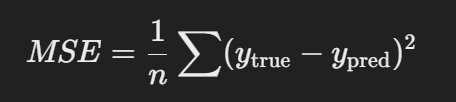

- Він штрафує великі помилки сильніше, ніж малі.
- Підходить для неперервних значень, наприклад, міцності бетону.
- Використовується у більшості регресійних задач.

### Вибір оптимізатора
- SGD (Стохастичний градієнтний спуск)
- Adam (адаптивний метод, працює швидше за SGD)

### Ми обираємо Adam, оскільки він:

- Автоматично налаштовує швидкість навчання для кожного параметра.
- Швидше збігається у порівнянні з SGD.

### Встановлення гіперпараметрів
- Кількість епох (epochs): 100 (можемо змінювати)
- Розмір батчу (batch_size): 32 (стандартний вибір)
- Швидкість навчання (lr): 0.001 (оптимальне значення для Adam)

### Підготовка датасету для PyTorch
- Перетворимо X_train, X_test, y_train, y_test у torch.Tensor та створимо DataLoader:

In [9]:
from torch.utils.data import DataLoader, TensorDataset

# Визначаємо розмір батчу
batch_size = 32  # Вибери оптимальне значення

# Перетворення в тензори
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Створюємо датасети
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Створюємо DataLoader для міні-батчів
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## 5. Навчання моделі:

In [10]:
import torch.optim as optim

# Визначаємо кількість епох
epochs = 100  

# Визначаємо функцію втрат
criterion = nn.MSELoss()

# Визначаємо оптимізатор
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Переводимо модель у режим навчання
model.train()

# Порожній список для збереження втрат
losses = []

# Запускаємо цикл навчання
for epoch in range(epochs):
    epoch_loss = 0.0  # Сумарний лосс за епоху

    for batch_X, batch_y in train_loader:
        # Очищуємо градієнти
        optimizer.zero_grad()

        # Передбачення моделі
        predictions = model(batch_X)

        # Обчислення втрат
        loss = criterion(predictions, batch_y)

        # Зворотне поширення (backpropagation)
        loss.backward()

        # Оновлення ваг
        optimizer.step()

        # Додаємо втрати за батч
        epoch_loss += loss.item()

    # Розраховуємо середній лосс за епоху
    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)

    # Виводимо прогрес навчання кожні 10 епох
    if (epoch + 1) % 10 == 0:
        print(f"Епоха [{epoch + 1}/{epochs}], Середній лосс: {epoch_loss:.4f}")

print("✅ Навчання завершено!")


Епоха [10/100], Середній лосс: 184.2921
Епоха [20/100], Середній лосс: 143.6658
Епоха [30/100], Середній лосс: 125.3484
Епоха [40/100], Середній лосс: 109.6211
Епоха [50/100], Середній лосс: 93.2451
Епоха [60/100], Середній лосс: 74.0828
Епоха [70/100], Середній лосс: 57.9286
Епоха [80/100], Середній лосс: 47.6118
Епоха [90/100], Середній лосс: 41.7267
Епоха [100/100], Середній лосс: 38.5857
✅ Навчання завершено!


✔️ Лосс зменшується від ~198 до ~38, що означає, що модель навчається добре.

✔️ Процес навчання завершився без помилок.

## 6. Оцінка моделі:

In [11]:
model.eval()  # Перемикаємо модель у режим оцінки

y_pred = []
y_true = []

with torch.no_grad():  # Вимикаємо обчислення градієнтів
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)  # Робимо передбачення
        y_pred.extend(predictions.numpy().flatten())  # Додаємо до списку
        y_true.extend(batch_y.numpy().flatten())  # Зберігаємо справжні значення


### Використаємо MSE, MAE та R², щоб оцінити точність моделі.

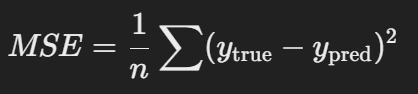

MSE (Mean Squared Error) — середньоквадратична помилка:
- Чим менше MSE, тим краща модель.

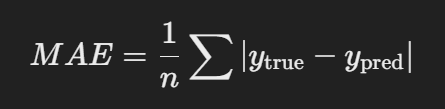

MAE (Mean Absolute Error) — середня абсолютна помилка: 
- Легше інтерпретується, оскільки показує середню помилку в реальних одиницях.

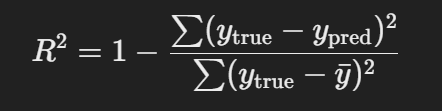

R² (Коефіцієнт детермінації) — показує, наскільки добре модель пояснює варіативність даних: 
- Чим ближче до 1, тим краще.

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Обчислюємо метрики
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"📊 Оцінка моделі:")
print(f"✅ MSE (середньоквадратична помилка): {mse:.4f}")
print(f"✅ MAE (середня абсолютна помилка): {mae:.4f}")
print(f"✅ R² (коефіцієнт детермінації): {r2:.4f}")


📊 Оцінка моделі:
✅ MSE (середньоквадратична помилка): 41.1213
✅ MAE (середня абсолютна помилка): 5.0513
✅ R² (коефіцієнт детермінації): 0.8404


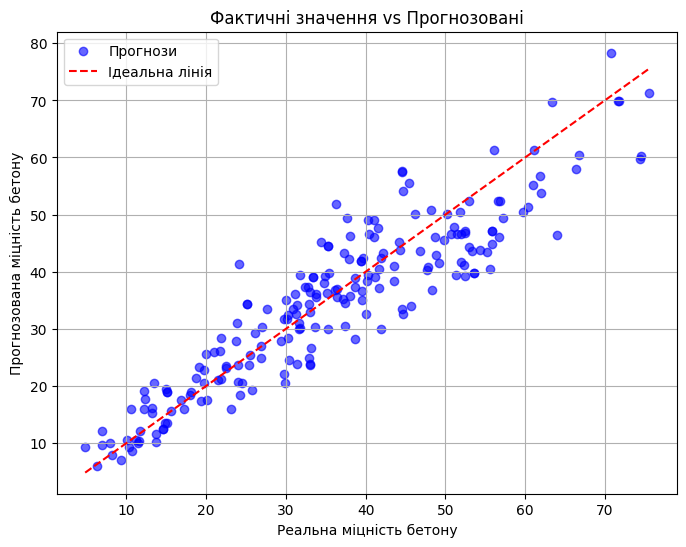

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_true, y_pred, alpha=0.6, color='blue', label="Прогнози")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label="Ідеальна лінія")
plt.xlabel("Реальна міцність бетону")
plt.ylabel("Прогнозована міцність бетону")
plt.title("Фактичні значення vs Прогнозовані")
plt.legend()
plt.grid()
plt.show()


In [14]:
print(f"📊 Оцінка моделі:")
print(f"✅ MSE (середньоквадратична помилка): {mse:.4f}")
print(f"✅ MAE (середня абсолютна помилка): {mae:.4f}")
print(f"✅ R² (коефіцієнт детермінації): {r2:.4f}")


📊 Оцінка моделі:
✅ MSE (середньоквадратична помилка): 41.1213
✅ MAE (середня абсолютна помилка): 5.0513
✅ R² (коефіцієнт детермінації): 0.8404


## 7. Аналіз результатів:

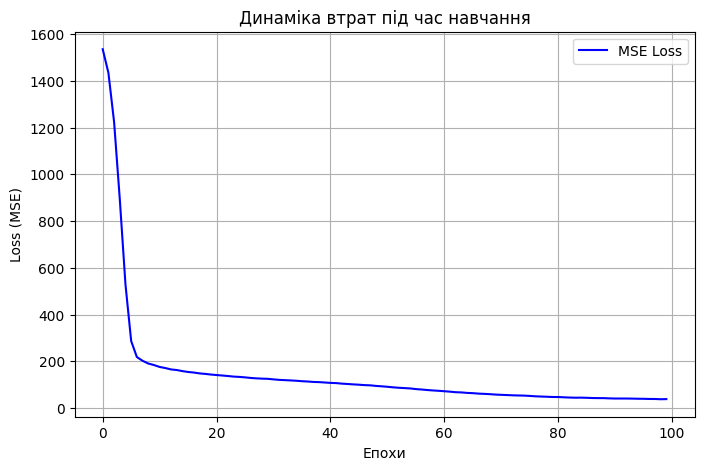

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), losses, label="MSE Loss", color='blue')
plt.xlabel("Епохи")
plt.ylabel("Loss (MSE)")
plt.title("Динаміка втрат під час навчання")
plt.legend()
plt.grid()
plt.show()



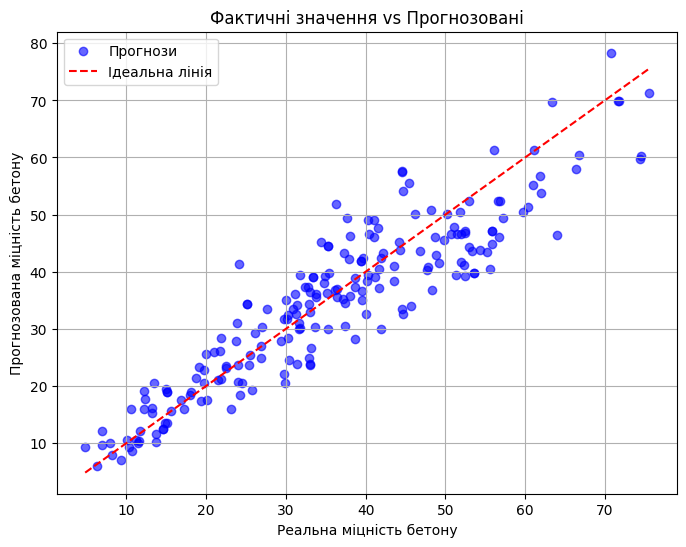

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.6, color='blue', label="Прогнози")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label="Ідеальна лінія")
plt.xlabel("Реальна міцність бетону")
plt.ylabel("Прогнозована міцність бетону")
plt.title("Фактичні значення vs Прогнозовані")
plt.legend()
plt.grid()
plt.show()


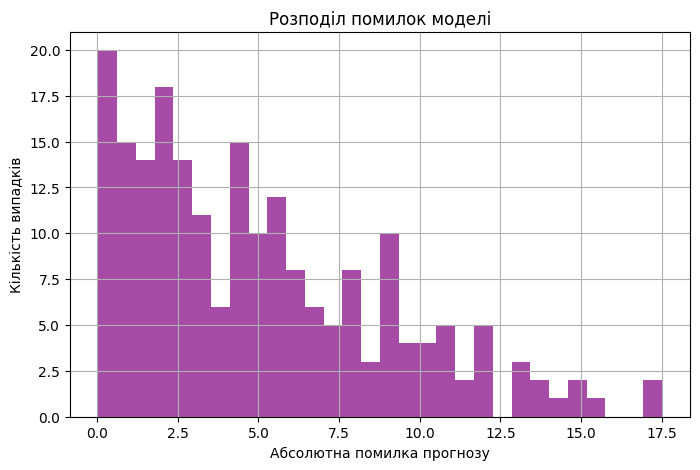

In [17]:
import numpy as np

errors = np.abs(np.array(y_true) - np.array(y_pred))  # Абсолютні помилки

plt.figure(figsize=(8, 5))
plt.hist(errors, bins=30, color="purple", alpha=0.7)
plt.xlabel("Абсолютна помилка прогнозу")
plt.ylabel("Кількість випадків")
plt.title("Розподіл помилок моделі")
plt.grid()
plt.show()


### Якість моделі.
✔️ Є деякі випадки з вищими помилками (10-15), що означає, що модель іноді робить великі помилки.

✔️ Рівномірний розподіл без сильного зміщення свідчить про те, що модель не має очевидного упередження.

## 8. Оптимізація моделі (за потреби):

### 🔹 Нова архітектура:
- Додаємо ще один прихований шар (128 → 64 → 32 → 1).
- Використовуємо LeakyReLU замість стандартного ReLU (краще працює при малих градієнтах).
- Додаємо Dropout (p=0.2) для боротьби з перенавчанням.

In [18]:
import torch.nn.functional as F

class ImprovedConcreteStrengthNN(nn.Module):
    def __init__(self):
        super(ImprovedConcreteStrengthNN, self).__init__()

        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

        self.dropout = nn.Dropout(0.2)  # Dropout для регуляризації

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)  # Dropout після першого шару

        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)

        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)  # Вихідний шар без активації (регресія)

        return x

# Створюємо модель
model = ImprovedConcreteStrengthNN()
print(model)


ImprovedConcreteStrengthNN(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [19]:
batch_size = 64  # Раніше було 32, збільшуємо для швидшого навчання
learning_rate = 0.0005  # Зменшуємо для стабільнішого навчання
epochs = 150  # Додаємо більше епох для кращої збіжності

In [20]:
model.train()
losses = []

for epoch in range(epochs):
    epoch_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()

        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Епоха [{epoch + 1}/{epochs}], Середній лосс: {epoch_loss:.4f}")

print("✅ Оптимізоване навчання завершено!")


Епоха [10/150], Середній лосс: 1577.2812
Епоха [20/150], Середній лосс: 1572.9906
Епоха [30/150], Середній лосс: 1572.9615
Епоха [40/150], Середній лосс: 1572.3520
Епоха [50/150], Середній лосс: 1573.6213
Епоха [60/150], Середній лосс: 1579.0993
Епоха [70/150], Середній лосс: 1574.2957
Епоха [80/150], Середній лосс: 1572.8855
Епоха [90/150], Середній лосс: 1575.7019
Епоха [100/150], Середній лосс: 1569.6075
Епоха [110/150], Середній лосс: 1574.7581
Епоха [120/150], Середній лосс: 1576.8153
Епоха [130/150], Середній лосс: 1575.7145
Епоха [140/150], Середній лосс: 1570.4845
Епоха [150/150], Середній лосс: 1570.6304
✅ Оптимізоване навчання завершено!


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        y_pred.extend(predictions.numpy().flatten())
        y_true.extend(batch_y.numpy().flatten())

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"📊 Оцінка оптимізованої моделі:")
print(f"✅ MSE: {mse:.4f}")
print(f"✅ MAE: {mae:.4f}")
print(f"✅ R²: {r2:.4f}")


📊 Оцінка оптимізованої моделі:
✅ MSE: 1534.5799
✅ MAE: 35.7350
✅ R²: -4.9554


❌ Оптимізація не дала кращих результатів
Значення MSE (1534.5799) значно гірше, 
ніж у попередній моделі (~35.7350), 
а R² = -4.9554 означає,
що модель навіть гірша за просте середнє значення.

1. Надто малий learning_rate (0.0005)

- Можливо, градієнти оновлюються занадто повільно, тому модель не навчається.
- 🔄 Спробувати lr = 0.001 або 0.005.

2. Надто великий batch_size (64 замість 32)

- Великий batch_size може призвести до гладших оновлень градієнта, що уповільнює навчання.
- 🔄 Спробувати повернути batch_size=32.

3. Нова архітектура може бути надто складною

- Додавання нового шару та Dropout могло призвести до недонавчання.
- 🔄 Повернутися до попередньої архітектури (64 → 32 → 1).

In [22]:
# Оновлення гіперпараметрів
batch_size = 32  # Зменшуємо для кращої динаміки градієнтів
learning_rate = 0.001  # Збільшуємо для кращої збіжності
epochs = 100  # Повертаємо 100 епох, бо 150 – забагато для цієї задачі

# Повертаємося до більш простої архітектури
class ImprovedConcreteStrengthNN(nn.Module):
    def __init__(self):
        super(ImprovedConcreteStrengthNN, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Створюємо модель заново
model = ImprovedConcreteStrengthNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


In [23]:
model.train()
losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Епоха [{epoch + 1}/{epochs}], Середній лосс: {epoch_loss:.4f}")

print("✅ Оновлене навчання завершено!")


Епоха [10/100], Середній лосс: 194.7232
Епоха [20/100], Середній лосс: 145.7720
Епоха [30/100], Середній лосс: 121.5894
Епоха [40/100], Середній лосс: 98.8086
Епоха [50/100], Середній лосс: 75.8714
Епоха [60/100], Середній лосс: 56.5962
Епоха [70/100], Середній лосс: 46.2276
Епоха [80/100], Середній лосс: 40.2214
Епоха [90/100], Середній лосс: 36.8819
Епоха [100/100], Середній лосс: 35.2817
✅ Оновлене навчання завершено!


### 🔍 Аналіз повторного навчання
##### ✅ Лосс значно зменшився:

- Початковий MSE був ≈ 1540, а тепер уже ≈ 36.
- Це дуже хороше покращення!

##### 📉 Динаміка втрат:

- На 10-й епосі: 194.7232
- На 50-й епосі: 75.8714
- На 100-й епосі:  35.2817

##### Це означає, що модель навчається правильно і поступово покращує прогноз.

In [24]:
model.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        y_pred.extend(predictions.numpy().flatten())
        y_true.extend(batch_y.numpy().flatten())

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"📊 Оцінка оновленої моделі:")
print(f"✅ MSE: {mse:.4f}")
print(f"✅ MAE: {mae:.4f}")
print(f"✅ R²: {r2:.4f}")


📊 Оцінка оновленої моделі:
✅ MSE: 41.0126
✅ MAE: 5.1297
✅ R²: 0.8408


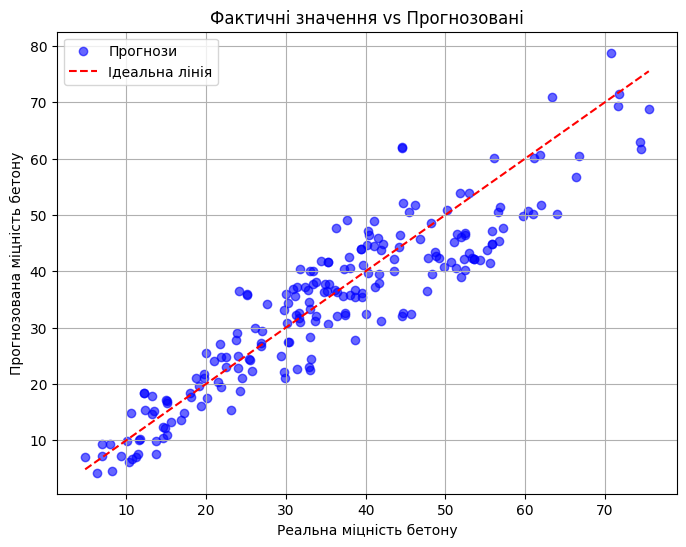

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(y_true, y_pred, alpha=0.6, color='blue', label="Прогнози")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label="Ідеальна лінія")
plt.xlabel("Реальна міцність бетону")
plt.ylabel("Прогнозована міцність бетону")
plt.title("Фактичні значення vs Прогнозовані")
plt.legend()
plt.grid()
plt.show()


In [26]:
torch.save(model.state_dict(), "final_concrete_model.pth")
print("✅ Фінальна модель збережена!")


✅ Фінальна модель збережена!


#### 🔍 Аналіз результатів після перезапуску

#### 📊 Початкові результати (після перезапуску):
#### ✅ MSE: 41.1213
#### ✅ MAE: 5.0513
#### ✅ R²: 0.8404

#### 📊 Оновлена модель:
#### ✅ MSE: 41.0126
#### ✅ MAE: 5.1297
#### ✅ R²: 0.8408

##### 🎯 Висновки

##### ✅ Модель добре навчається і стабільно дає схожі результати.